<a href="https://colab.research.google.com/github/RMottram/2D-CNN/blob/master/2D_CNN_colab_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1]:
!nvidia-smi

Thu Jul 22 10:04:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null

In [1]:
## libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [2]:
train_normal = []
test_normal = []
train_smurf = []
test_smurf = []
train_ip = []
test_ip = []
train_port = []
test_port = []
train_nmap = []
test_nmap = []

for i in glob.glob('/content/split_images/64x64_V2/70-30/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/split_images/64x64_V2/70-30/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/split_images/64x64_V2/70-30/train_smurf/train_smurf_equ_*.jpg', recursive=True):
    train_smurf.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/split_images/64x64_V2/70-30/test_smurf/test_smurf_equ_*.jpg', recursive=True):
    test_smurf.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

for m in glob.glob('/content/split_images/64x64_V2/70-30/train_ip/train_ip_equ_*.jpg', recursive=True):
    train_ip.append(cv2.imread(m, cv2.IMREAD_GRAYSCALE))

for n in glob.glob('/content/split_images/64x64_V2/70-30/test_ip/test_ip_equ_*.jpg', recursive=True):
    test_ip.append(cv2.imread(n, cv2.IMREAD_GRAYSCALE))
    
for o in glob.glob('/content/split_images/64x64_V2/70-30/train_port/train_port_equ_*.jpg', recursive=True):
    train_port.append(cv2.imread(o, cv2.IMREAD_GRAYSCALE))

for p in glob.glob('/content/split_images/64x64_V2/70-30/test_port/test_port_equ_*.jpg', recursive=True):
    test_port.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE))
    
for q in glob.glob('/content/split_images/64x64_V2/70-30/train_nmap/train_nmap_equ_*.jpg', recursive=True):
    train_nmap.append(cv2.imread(q, cv2.IMREAD_GRAYSCALE))

for r in glob.glob('/content/split_images/64x64_V2/70-30/test_nmap/test_nmap_equ_*.jpg', recursive=True):
    test_nmap.append(cv2.imread(r, cv2.IMREAD_GRAYSCALE))
    


train_normal = np.array(train_normal)
test_normal = np.array(test_normal)
train_smurf = np.array(train_smurf)
test_smurf = np.array(test_smurf)
train_ip = np.array(train_ip)
test_ip = np.array(test_ip)
train_port = np.array(train_port)
test_port = np.array(test_port)
train_nmap = np.array(train_nmap)
test_nmap = np.array(test_nmap)

In [3]:
print(f'Normal train\t{np.shape(train_normal)}\nNormal test\t{np.shape(test_normal)}\nSmurf train\t{np.shape(train_smurf)}\nSmurf test\t{np.shape(test_smurf)}\nIP train\t{np.shape(train_ip)}\nIP test\t\t{np.shape(test_ip)}')
print(f'Port train\t{np.shape(train_port)}\nPort test\t{np.shape(test_port)}\nNmap train\t{np.shape(train_nmap)}\nNmap test\t{np.shape(test_nmap)}')

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

Normal train	(1500, 64, 64)
Normal test	(643, 64, 64)
Smurf train	(107, 64, 64)
Smurf test	(46, 64, 64)
IP train	(4757, 64, 64)
IP test		(2039, 64, 64)
Port train	(1557, 64, 64)
Port test	(667, 64, 64)
Nmap train	(56, 64, 64)
Nmap test	(24, 64, 64)


In [9]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_normal = np.fliplr(train_normal)
vert_flip_train_smurf = np.fliplr(train_smurf)
vert_flip_train_ip = np.fliplr(train_ip)
vert_flip_train_port = np.fliplr(train_port)
vert_flip_train_nmap = np.fliplr(train_nmap)

## flip training images horizonatally
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)
hor_flip_train_smurf = np.rot90(train_smurf, axes = (1,2), k = 2)
hor_flip_train_ip = np.rot90(train_ip, axes = (1,2), k = 2)
hor_flip_train_port = np.rot90(train_port, axes = (1,2), k = 2)
hor_flip_train_nmap = np.rot90(train_nmap, axes = (1,2), k = 2)

## rotate training images left and right once each
# rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
# rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_normal = np.fliplr(test_normal)
vert_flip_test_smurf = np.fliplr(test_smurf)
vert_flip_test_ip = np.fliplr(test_ip)
vert_flip_test_port = np.fliplr(test_port)
vert_flip_test_nmap = np.fliplr(test_nmap)

## flip testing images horizonatally
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)
hor_flip_test_smurf = np.rot90(test_smurf, axes = (1,2), k = 2)
hor_flip_test_ip = np.rot90(test_ip, axes = (1,2), k = 2)
hor_flip_test_port = np.rot90(test_port, axes = (1,2), k = 2)
hor_flip_test_nmap = np.rot90(test_nmap, axes = (1,2), k = 2)

## rotate testing images left and right once each
# rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
# rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

train = np.vstack((train_normal, vert_flip_train_normal, hor_flip_train_normal, train_smurf, vert_flip_train_smurf, hor_flip_train_smurf, train_ip, vert_flip_train_ip, hor_flip_train_ip, train_port, vert_flip_train_port, hor_flip_train_port, train_nmap, vert_flip_train_nmap, hor_flip_train_nmap))
test = np.vstack((test_normal, vert_flip_test_normal, hor_flip_test_normal, test_smurf, vert_flip_test_smurf, hor_flip_test_smurf, test_ip, vert_flip_test_ip, hor_flip_test_ip, test_port, vert_flip_test_port, hor_flip_test_port, test_nmap, vert_flip_test_nmap, hor_flip_test_nmap))

In [4]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_smurf, train_ip, train_port, train_nmap))
test = np.vstack((test_normal, test_smurf, test_ip, test_port, test_nmap))

train.shape, test.shape

((7977, 64, 64), (3419, 64, 64))

In [5]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((7977, 64, 64, 1), (3419, 64, 64, 1))

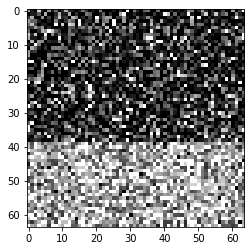

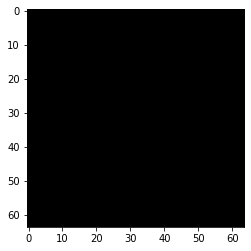

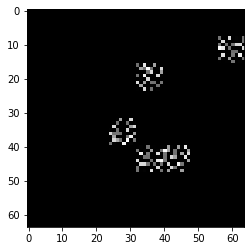

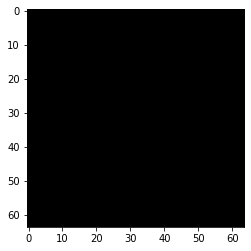

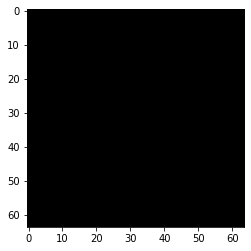

In [ ]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [6]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []

for i in range(0, train_normal.shape[0]):
    training_labels.append('Normal')

for j in range(0, train_smurf.shape[0]):
    training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
for m in range(0, train_nmap.shape[0]):
    training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0]):
    testing_labels.append('Normal')

for j in range(0, test_smurf.shape[0]):
    testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
for m in range(0, test_nmap.shape[0]):
    testing_labels.append('Nmap-Sweep')

In [13]:
pd.DataFrame(training_labels)

,0
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
9111,Nmap-Sweep
9112,Nmap-Sweep
9113,Nmap-Sweep
9114,Nmap-Sweep


In [ ]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []

for i in range(0, train_normal.shape[0] + vert_flip_train_normal.shape[0] + hor_flip_train_normal.shape[0]):
    training_labels.append('Normal')

for j in range(0, train_smurf.shape[0] + vert_flip_train_smurf.shape[0] + hor_flip_train_smurf.shape[0]):
    training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0] + vert_flip_train_ip.shape[0] + hor_flip_train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0] + vert_flip_train_port.shape[0] + hor_flip_train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
for m in range(0, train_nmap.shape[0] + vert_flip_train_nmap.shape[0] + hor_flip_train_nmap.shape[0]):
    training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0] + vert_flip_test_normal.shape[0] + hor_flip_test_normal.shape[0]):
    testing_labels.append('Normal')

for j in range(0, test_smurf.shape[0] + vert_flip_test_smurf.shape[0] + hor_flip_test_smurf.shape[0]):
    testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0] + vert_flip_test_ip.shape[0] + hor_flip_test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0] + vert_flip_test_port.shape[0] + hor_flip_test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
for m in range(0, test_nmap.shape[0] + vert_flip_test_nmap.shape[0] + hor_flip_test_nmap.shape[0]):
    testing_labels.append('Nmap-Sweep')

In [ ]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [7]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(      IP-Sweep  Nmap-Sweep  Normal  Port-Sweep  Smurf-DDoS
 0            0           0       1           0           0
 1            0           0       1           0           0
 2            0           0       1           0           0
 3            0           0       1           0           0
 4            0           0       1           0           0
 ...        ...         ...     ...         ...         ...
 7972         0           1       0           0           0
 7973         0           1       0           0           0
 7974         0           1       0           0           0
 7975         0           1       0           0           0
 7976         0           1       0           0           0
 
 [7977 rows x 5 columns],
       IP-Sweep  Nmap-Sweep  Normal  Port-Sweep  Smurf-DDoS
 0            0           0       1           0           0
 1            0           0       1           0           0
 2            0           0       1           0           0
 3          

In [8]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 42)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 42)

In [9]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(8, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(256, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(16, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation = 'softmax'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         40        
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        528       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8

In [10]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 128, epochs = 250)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/250
63/63 [==============================] - 32s 11ms/step - loss: 1.1809 - accuracy: 0.6312
Epoch 2/250
63/63 [==============================] - 1s 8ms/step - loss: 0.9058 - accuracy: 0.6565
Epoch 3/250
63/63 [==============================] - 1s 8ms/step - loss: 0.9009 - accuracy: 0.6554
Epoch 4/250
63/63 [==============================] - 1s 8ms/step - loss: 0.8882 - accuracy: 0.6645
Epoch 5/250
63/63 [==============================] - 1s 9ms/step - loss: 0.8827 - accuracy: 0.6658
Epoch 6/250
63/63 [==============================] - 1s 9ms/step - loss: 0.8740 - accuracy: 0.6761
Epoch 7/250
63/63 [==============================] - 1s 9ms/step - loss: 0.8705 - accuracy: 0.6783
Epoch 8/250
63/63 [==============================] - 1s 8ms/step - loss: 0.8635 - accuracy: 0.6796
Epoch 9/250
63/63 [==============================] - 1s 8ms/step - loss: 0.8603 - accuracy: 0.6846
Epoch 10/250
63/63 [==============================] - 1s 8ms/step - loss: 0.8610 - accuracy: 0.6828
Epoch 1

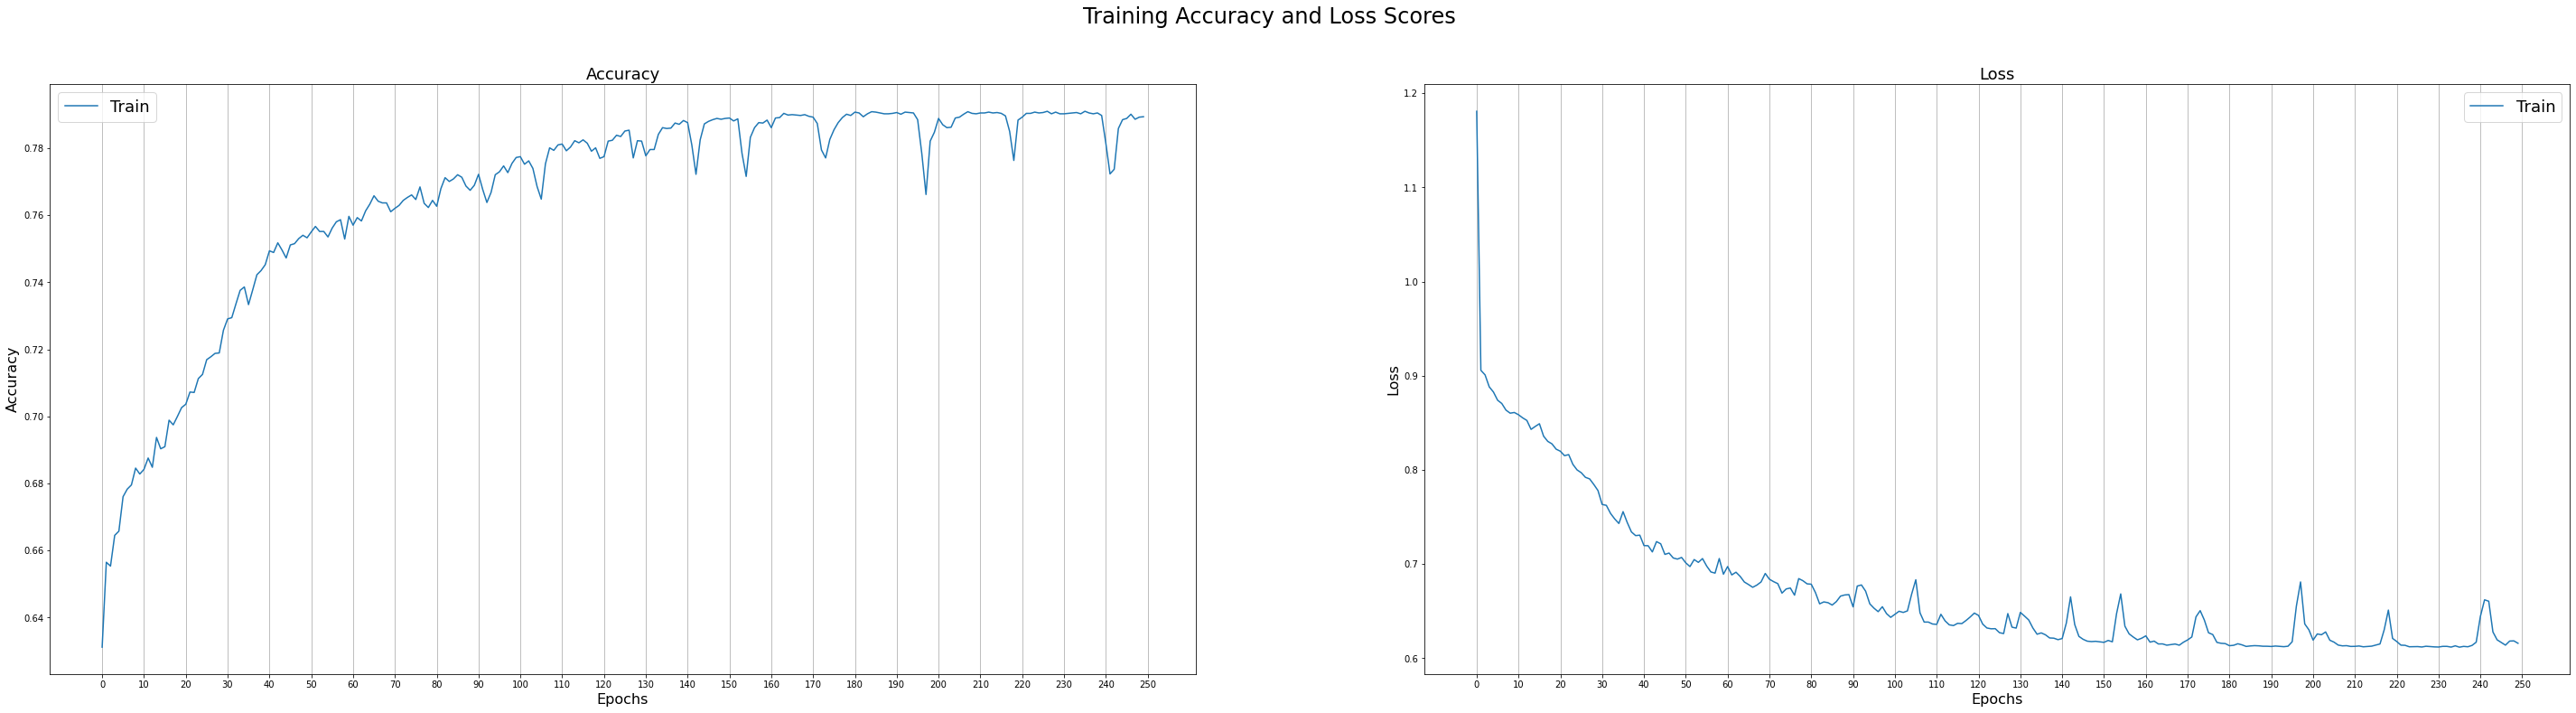

In [11]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 260, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 260, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [12]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 128, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.8759	Accuracy = 66.60000000000001%


In [13]:
preds = (cnn.predict(test) > 0.5)
ypreds = np.argmax(test, axis = 1)

# label_enc = LabelEnco/transform(ytest)


# print('\tIP\tNmap\tNormal\tPort\tSmurf\n')
preds

array([[ True, False, False, False, False],
       [False, False, False,  True, False],
       [ True, False, False, False, False],
       [False, False,  True, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [False, False,  True, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [False, False, False,  True, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [False, False, False,  True, False],
       [ True, False, False, Fal

In [14]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(8, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # # cnn.add(Dropout(0.5))

    # ## convolution 6
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dense(16, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(5, activation = 'softmax'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 128, epochs = 250)

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation Score - {round(score.mean(), 3)*100}%')
print(f'Model Cross Validation Scores - {score}')
print(f'Model Cross Validation standard deviation - {round(score.std(), 3)*100}')

Epoch 1/250
22/22 [==============================] - 1s 19ms/step - loss: 1.4875 - accuracy: 0.6143
Epoch 2/250
22/22 [==============================] - 0s 8ms/step - loss: 1.1052 - accuracy: 0.6537
Epoch 3/250
22/22 [==============================] - 0s 8ms/step - loss: 0.9393 - accuracy: 0.6508
Epoch 4/250
22/22 [==============================] - 0s 8ms/step - loss: 0.9165 - accuracy: 0.6541
Epoch 5/250
22/22 [==============================] - 0s 8ms/step - loss: 0.9006 - accuracy: 0.6611
Epoch 6/250
22/22 [==============================] - 0s 8ms/step - loss: 0.9075 - accuracy: 0.6581
Epoch 7/250
22/22 [==============================] - 0s 9ms/step - loss: 0.8959 - accuracy: 0.6567
Epoch 8/250
22/22 [==============================] - 0s 9ms/step - loss: 0.8883 - accuracy: 0.6644
Epoch 9/250
22/22 [==============================] - 0s 9ms/step - loss: 0.8757 - accuracy: 0.6706
Epoch 10/250
22/22 [==============================] - 0s 9ms/step - loss: 0.8789 - accuracy: 0.6636
Epoch 11

In [16]:
targets = ['IP',	'Nmap', 'Normal', 'Port', 'Smurf']
cr = classification_report(ytest, preds, target_names=targets, zero_division=0)
cm = confusion_matrix(ytest.values.argmax(axis = 1), preds.argmax(axis = 1))

In [17]:
cm_df = pd.DataFrame(cm,
                     index = targets, 
                     columns = targets)

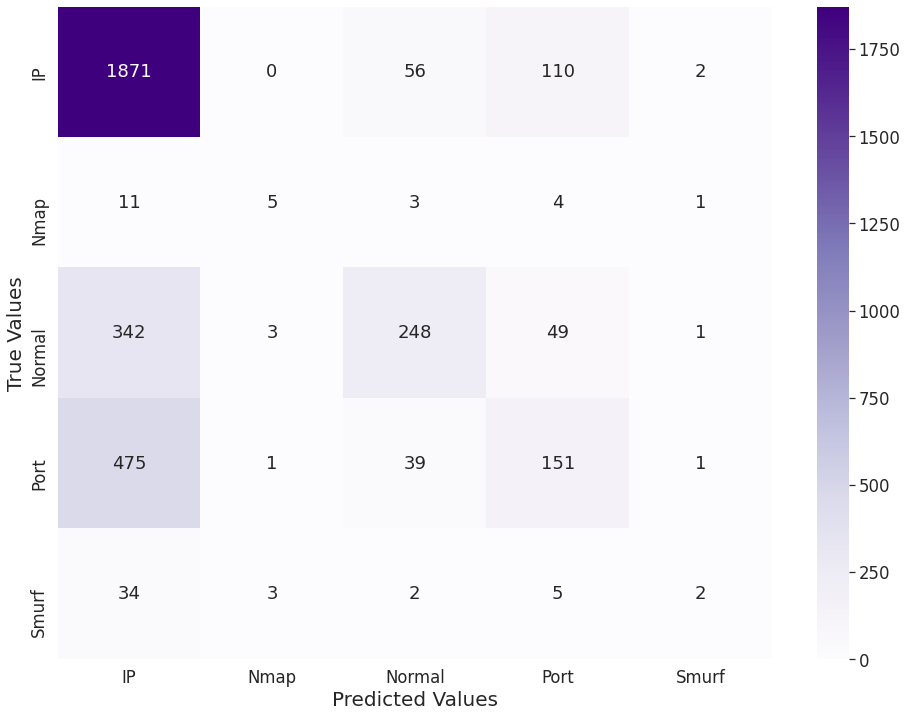

              precision    recall  f1-score   support

          IP       0.68      0.92      0.78      2039
        Nmap       0.42      0.21      0.28        24
      Normal       0.71      0.39      0.50       643
        Port       0.47      0.23      0.31       667
       Smurf       0.29      0.04      0.08        46

   micro avg       0.67      0.67      0.67      3419
   macro avg       0.51      0.36      0.39      3419
weighted avg       0.64      0.67      0.62      3419
 samples avg       0.67      0.67      0.67      3419



In [18]:
plt.figure(figsize=(16,12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, annot=True, cmap = 'Purples', fmt='1')
plt.ylabel('True Values', fontsize = '20')
plt.xlabel('Predicted Values', fontsize = '20')
plt.show()

print(cr)

In [19]:
def perf_measure(y_actual, y_pred, labels):
    labels = targets
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return(print(f'{labels}\nTP - {TP}\nFP - {FP}\nTN - {TN}\nFN - {FN}'))

In [20]:
perf_measure(ytest.values.argmax(axis = 1), preds.argmax(axis = 1), targets)

['IP', 'Nmap', 'Normal', 'Port', 'Smurf']
TP - [1871, 5, 248, 151, 2]
FP - [862, 7, 100, 168, 5]
TN - [406, 2272, 2029, 2126, 2275]
FN - [280, 1135, 1042, 974, 1137]
